In [158]:
!zip -r figures.zip ./results/figures

updating: results/figures/ (stored 0%)
  adding: results/figures/best_xgb_heatmap_dist.png (deflated 0%)
  adding: results/figures/LinearDiscriminantAnalysis_ROC.png (deflated 10%)
  adding: results/figures/LinearDiscriminantAnalysis_waterfall_idx1.png (deflated 12%)
  adding: results/figures/LogisticRegression_beeswarm.png (deflated 12%)
  adding: results/figures/.ipynb_checkpoints/ (stored 0%)
  adding: results/figures/.ipynb_checkpoints/best_xgb_waterfall_idx1-checkpoint.png (deflated 12%)
  adding: results/figures/.ipynb_checkpoints/LogisticRegression_waterfall_idx1-checkpoint.png (deflated 13%)
  adding: results/figures/.ipynb_checkpoints/all_ROC-checkpoint.png (deflated 7%)
  adding: results/figures/XGBClassifier_ROC.png (deflated 11%)
  adding: results/figures/all_ROC.png (deflated 7%)
  adding: results/figures/RandomForestClassifier_feature_importance.png (deflated 28%)
  adding: results/figures/XGBClassifier_beeswarm.png (deflated 3%)
  adding: results/figures/best_xgb_beeswar

In [96]:
seed = 0

import os
import sys

utils_path = os.path.abspath("./utilities/")
sys.path.append(utils_path)

from load_data import load_fullECAI
from evaluation import *
from evaluation import _my_scorer

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import joblib
from joblib import Parallel, delayed
import shap

from igraph import Graph
import igraph as ig

In [143]:
import colorcet as cc

In [146]:
palette = cc.b_glasbey_category10

In [2]:
### LOAD DATA ###
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

In [ ]:
# ###### RECOVER BEST XGB and save it in a standard form

# from sklearn.metrics import f1_score, confusion_matrix

# grid = joblib.load('./results/XGBoost/GridSearchCV_22-03-22_03-27-03/GridSearchCV_22-03-22_03-27-03.pkl')
# model = grid.best_estimator_
# clf = model
# X_val = X_test

# y_pred_val = clf.predict(X_val)
# y_prob_val = clf.predict_proba(X_val)
    
# cf = confusion_matrix(y_test, y_pred_val)
# f1 = f1_score(y_test, y_pred_val)

# explainer = shap.Explainer(model)
# shap_test = explainer(X_val)

# path = './results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb.pkl'
# save_model(path, model.get_params(), shap_test, X_val, y_pred_val, y_prob_val, cf, f1)

In [139]:
def save_plot(model_path, fig_str):
    if not os.path.exists('results/figures'):
        os.makedirs('results/figures')
    
    model_name = model_path.split('/')[-1].split('.')[0]
    fig_name = 'results/figures/{}_{}.png'.format(model_name, fig_str)
    results = plt.savefig(fig_name, bbox_inches='tight', dpi=300, transparent=True)

    
def ROC(model_info, model_path, ax=None):
    if ax == None:
        ax = plt.gca()
        
    y_proba_1 = model_info['y_proba'][:,1]
    
    fig, ax = plt.subplots()
    RocCurveDisplay.from_predictions(y_test, y_proba_1, ax=ax)


def shap_bee(model_info, model_path):
    shap_test = model_info['shap_test']
    shap.plots.beeswarm(shap_test, max_display=19, show=False)
    
    save_plot(model_path, 'beeswarm')
    plt.show()
    
    
def shap_feat_importance(model_info, model_path):
    shap_test = model_info['shap_test']
    shap.summary_plot(shap_test, plot_type='bar', show=False, feature_names=model_info['shap_df'].columns)
    
    save_plot(model_path, 'feature_importance')
    plt.show()

    
def shap_waterfall(model_info, model_path, idx):
    shap_df = model_info['shap_df']
    shap_test = model_info['shap_test']
    
    sample_idx = shap_df.index[idx]
    shap.plots.waterfall(shap_test[idx], max_display=19, show=False)
    
    save_plot(model_path, 'waterfall_idx{}'.format(idx))
    plt.show()
    

def heatmap(model_info, model_path):
    shap_df = model_info['shap_df']
    shap_dist = euclidean_distances(shap_df)
    
    ax = sns.heatmap(shap_dist[np.argsort(y_test).values][:,np.argsort(y_test).values], xticklabels=False, yticklabels=False)
    ax = ax.invert_yaxis()
    
    save_plot(model_path, 'heatmap_dist')
    plt.show()
    
    
def compare():
    sns.boxplot(x="variable", y="value", data=pd.melt(results))
    plt.ylabel('Macro valor F1')
    plt.xlabel('Modelo')
    
    if not os.path.exists('results/figures'):
        os.makedirs('results/figures')
    plt.savefig('results/figures/mb_F1_CV.png', bbox_inches='tight', dpi=300, transparent=True)

In [80]:
models_paths = ['./results/XGBoost/GridSearchCV_22-03-22_03-27-03/models/best/best_xgb1.pkl', 
                './results/Basic/models/RandomForestClassifier.pkl', 
                './results/Basic/models/LogisticRegression.pkl',
                './results/Basic/models/LinearDiscriminantAnalysis.pkl',
                './results/Basic/models/XGBClassifier.pkl']

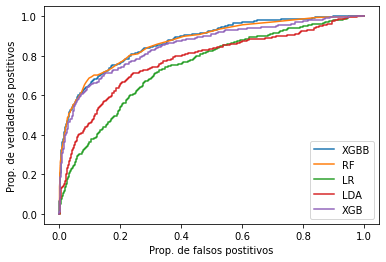

In [175]:
# ROC curves same figure
fig, ax = plt.subplots()
for i, model_path in enumerate(models_paths):
    model_name = model_path.split('/')[-1].split('.')[0]
    model_info = joblib.load(model_path)
    y_proba_1 = model_info['y_proba'][:,1]
    
    RocCurveDisplay.from_predictions(y_test, y_proba_1, ax=ax, color=palette[i], label=model_name)

ax.set_xlabel('Prop. de falsos postitivos')
ax.set_ylabel('Prop. de verdaderos postitivos')
ax.legend(labels=['XGBB', 'RF', 'LR', 'LDA', 'XGB'])
save_plot('/all.', 'ROC')

Text(0.5, 17.200000000000003, 'Hola')

In [164]:
plt.show()

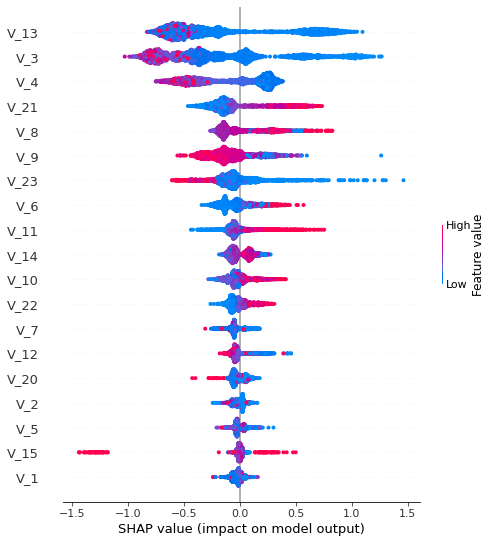

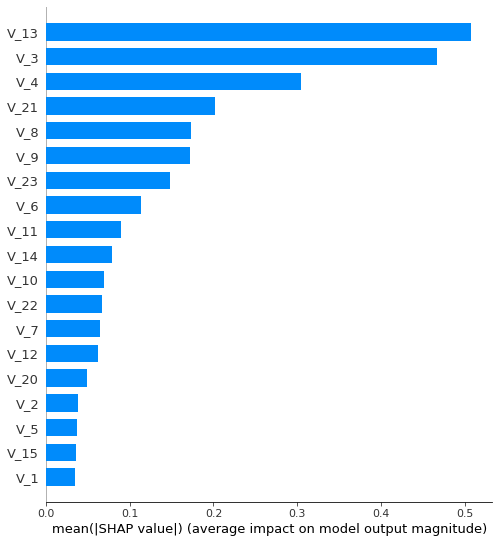

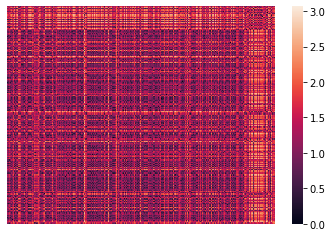

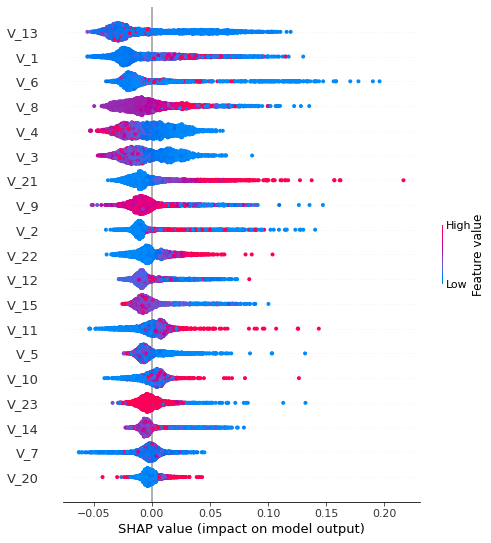

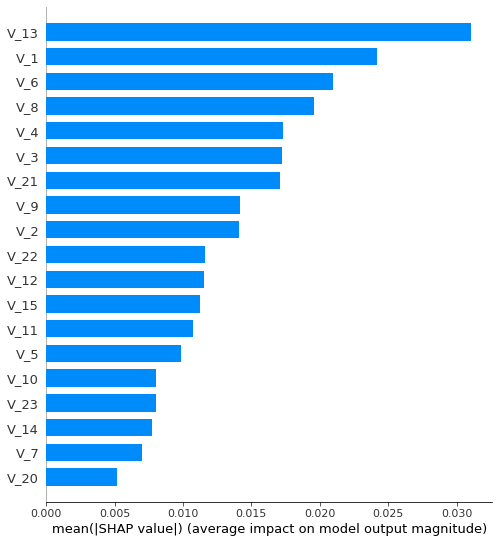

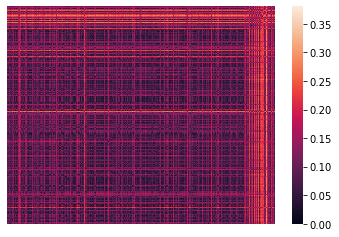

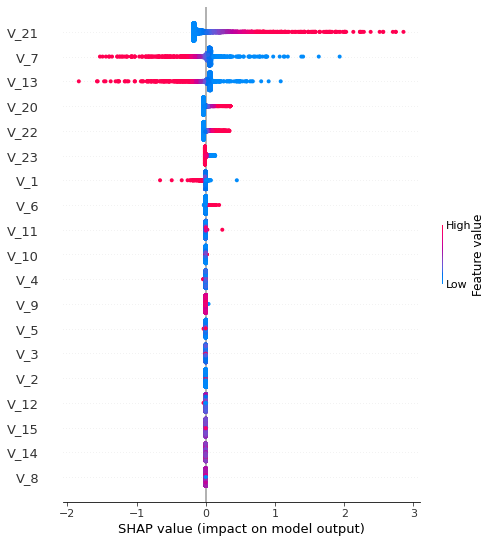

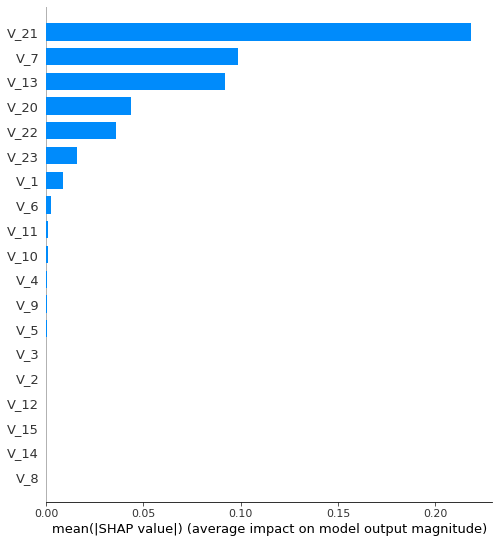

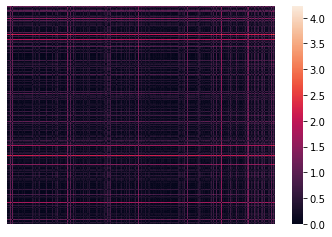

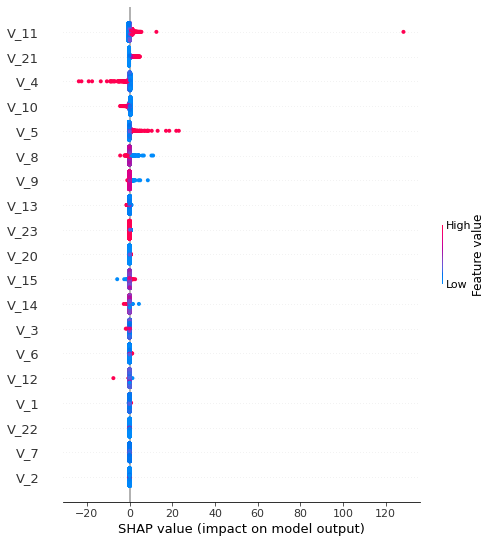

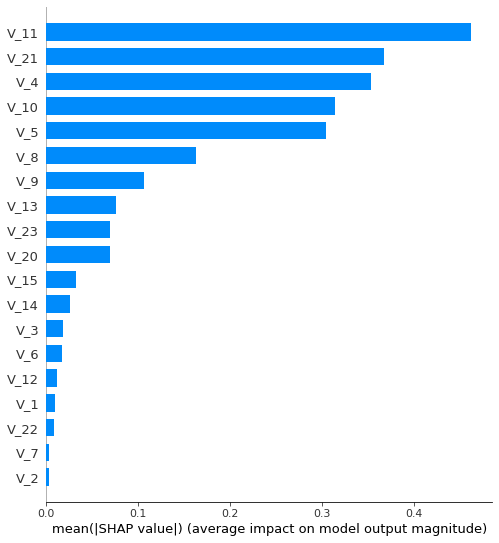

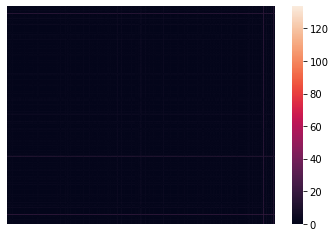

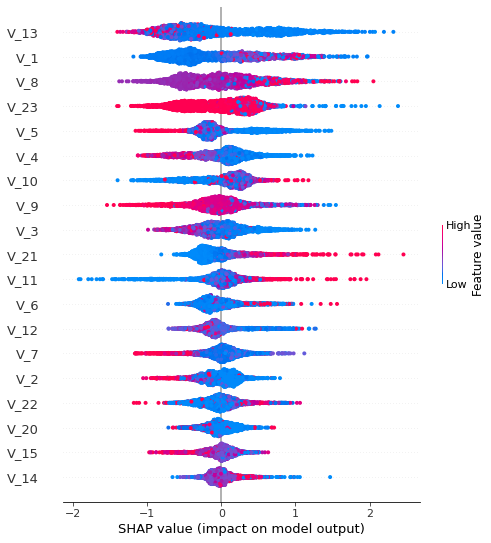

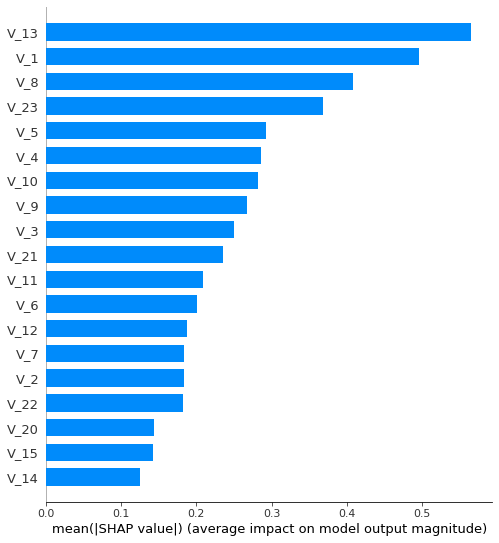

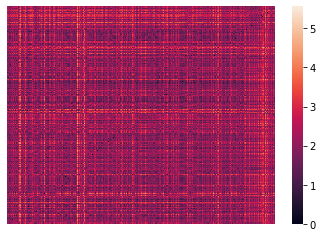

In [156]:
y_preds = []
for model_path in models_paths:
    model_info = joblib.load(model_path)
    shap_bee(model_info, model_path)
    shap_feat_importance(model_info, model_path)
    heatmap(model_info, model_path)
    
    # Recover predicitions for later
    y_preds.append(model_info['y_pred'])

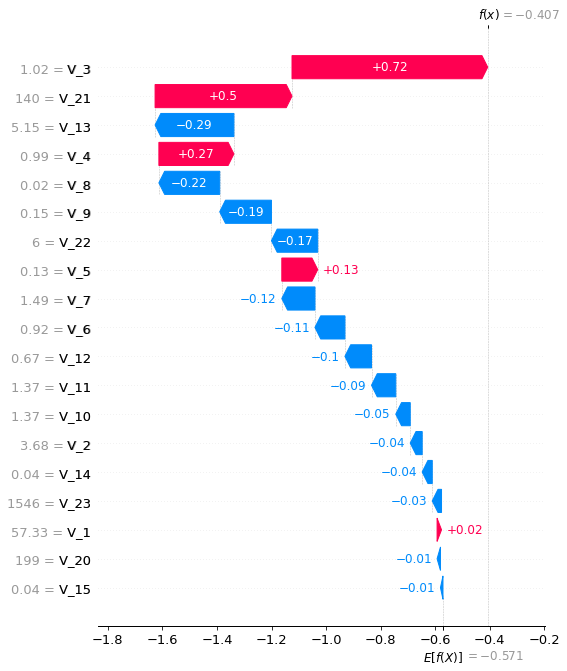

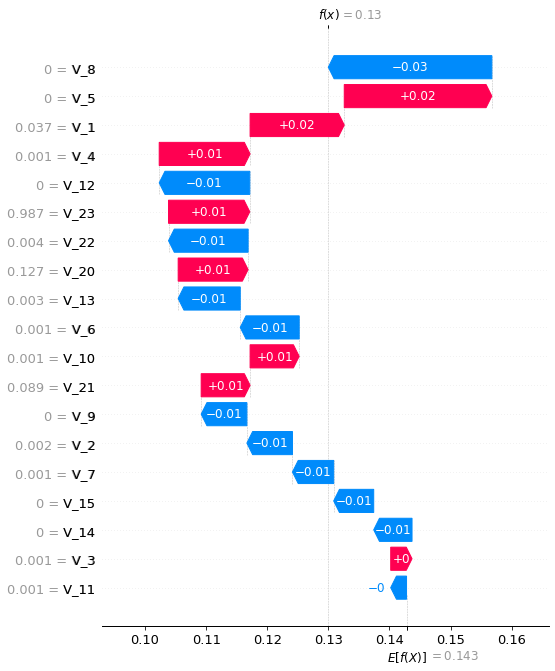

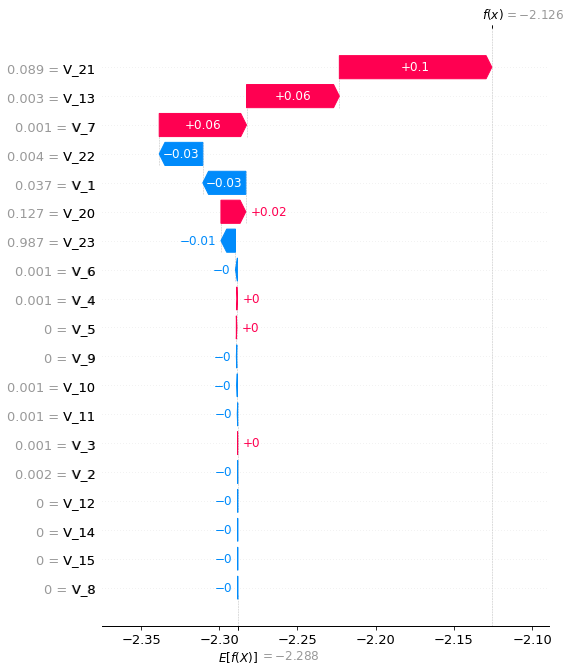

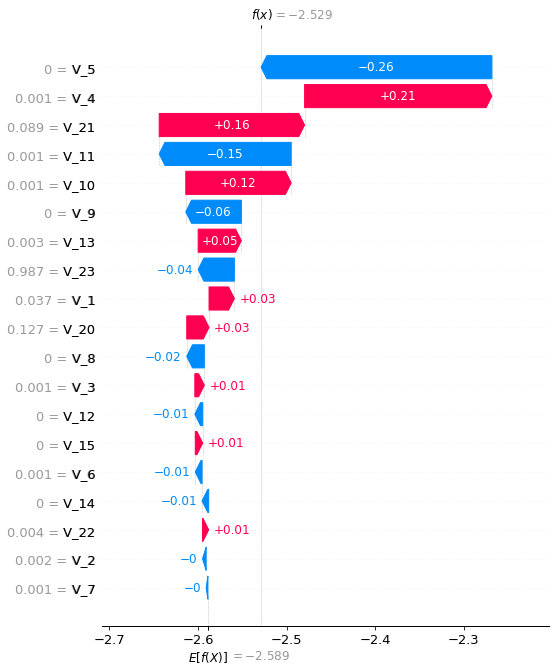

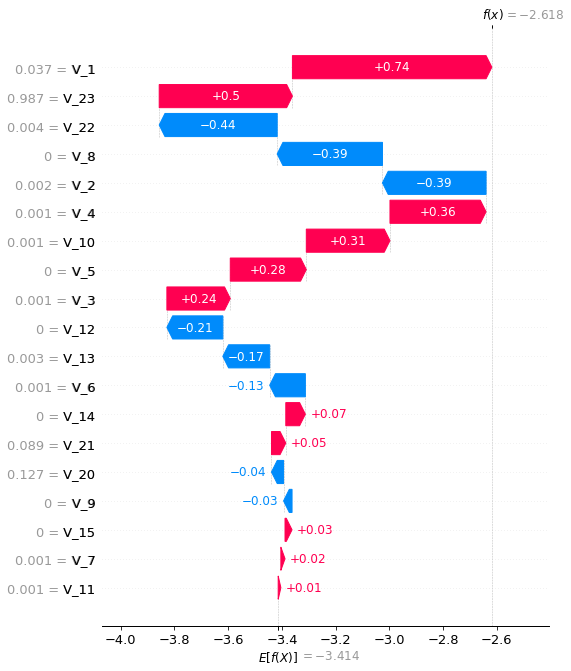

In [138]:
predicted_correctly = np.array([y_pred == y_test for y_pred in y_preds]).T
all_correct = np.all(predicted_correctly, axis=1)
one_all_correct_idx = np.where(all_correct == True)[0][0]

for model_path in models_paths:
    model_info = joblib.load(model_path)
    shap_waterfall(model_info, model_path, one_all_correct_idx)